# Import Packages

In [92]:
import pandas as pd
from pandasql import sqldf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Load Data

This Data was extracted from PeakTiming page for [FNB Maputo 10K Race](https://live.ultimate.dk/desktop/front/index.php?eventid=5987) that I participated by copying to a csv file. So I thought I could get some cool insights about the race itself and my performance

In [93]:
# Load data from excel file
df_race_results = pd.read_csv('FNB M10K23 Results.csv')


In [94]:
df_race_results.columns

Index(['Rank', 'Race No', 'Name', 'Nation', 'Categoria', 'Category', 'Time',
       'Unnamed: 7'],
      dtype='object')

In [95]:
df_race_results

,Rank,Race No,Name,Nation,Categoria,Category,Time,Unnamed: 7
0,1,1960,Abednico Mashaba,RSA,Federados,M20-39,00:31:21,NaN
1,2,3753,Princip Dlhovo,MOZ,FEDERADOS,M20-39,00:31:29,NaN
2,3,3750,Titosse Taimo,MOZ,FEDERADOS,M20-39,00:32:56,NaN
3,4,3751,Nazareno Domingos,MOZ,FEDERADOS,M20-39,00:33:18,NaN
4,5,1439,Bento Gervásio Ianquine Itato,MOZ,Veteranos (40-49),M40-49,00:34:23,NaN
...,...,...,...,...,...,...,...,...
2263,2264,3940,Júlio Monteiro,MOZ,Veteranos (40-49),M40-49,02:22:50,NaN
2264,2265,3894,Daniele Pepe,MOZ,Veteranos (50-59),M50-59,02:22:51,NaN
2265,2266,3863,Amad Mahomed,MOZ,Veteranos (50-59),M50-59,02:22:54,NaN
2266,2267,3173,Daniel Filepe Massango,MOZ,Populares (14-39),M60-69,02:22:58,NaN


# Exploratory Data Analysis

## Data Cleaning

Will now check for nulls and any inconsistencies to better clean up the data.

In [96]:
# check for null values
df_race_results.isnull().sum()

Rank             0
Race No          0
Name             0
Nation           0
Categoria        0
Category         0
Time             0
Unnamed: 7    2268
dtype: int64

In [97]:
# chek for duplicate values
df_race_results['Race No'].duplicated().sum()

0

In [98]:
# drop column Unnamed: 7 as no data is there
df_race_results.drop(df_race_results.columns[7], axis=1, inplace=True)

# We can drop also Race No as we will use the names if we need to identify records
df_race_results.drop(df_race_results.columns[1], axis=1, inplace=True)

In [99]:
# Convert the time column to datetime format
df_race_results['Time'] = pd.to_datetime(df_race_results['Time'],format='%H:%M:%S')

In [100]:
df_race_results.dtypes

Rank                  int64
Name                 object
Nation               object
Categoria            object
Category             object
Time         datetime64[ns]
dtype: object

In [101]:
df_race_results

,Rank,Name,Nation,Categoria,Category,Time
0,1,Abednico Mashaba,RSA,Federados,M20-39,1900-01-01 00:31:21
1,2,Princip Dlhovo,MOZ,FEDERADOS,M20-39,1900-01-01 00:31:29
2,3,Titosse Taimo,MOZ,FEDERADOS,M20-39,1900-01-01 00:32:56
3,4,Nazareno Domingos,MOZ,FEDERADOS,M20-39,1900-01-01 00:33:18
4,5,Bento Gervásio Ianquine Itato,MOZ,Veteranos (40-49),M40-49,1900-01-01 00:34:23
...,...,...,...,...,...,...
2263,2264,Júlio Monteiro,MOZ,Veteranos (40-49),M40-49,1900-01-01 02:22:50
2264,2265,Daniele Pepe,MOZ,Veteranos (50-59),M50-59,1900-01-01 02:22:51
2265,2266,Amad Mahomed,MOZ,Veteranos (50-59),M50-59,1900-01-01 02:22:54
2266,2267,Daniel Filepe Massango,MOZ,Populares (14-39),M60-69,1900-01-01 02:22:58


Analysing category and categoria for duplicates and possible feature engineering. I decided to use pandasql as I'm currently pretty accostumed in working with SQL at work and readability can be musch simple to everyone.

In [102]:
sqldf("""SELECT distinct Categoria from df_race_results""")

,Categoria
0,Federados
1,FEDERADOS
2,Veteranos (40-49)
3,Populares (14-39)
4,POPULARES (14-39)
5,Veteranos (60+)
6,VETERANOS 50
7,VETERANOS (40-49)
8,Veteranos (50-59)
9,POPULARES


It seems there are duplicate categories due to use of different letter cases and details such as age group. Need to Merge them later. There's also 1 mispelled category that I can also merge

In [103]:
# Check categories in category column
sqldf("""SELECT distinct category from df_race_results""")

,Category
0,M20-39
1,M40-49
2,W20-39
3,M60-69
4,M50-59
5,M15-19
6,W15-19
7,W40-49
8,W60-69
9,W50-59


In this column we also have Age groups but split by gender. We can you this to create columns for Age group and gender. let's confirm if the the the classes in Categoria with age details match the age groups in categoria. Also let's differentiate both columns as category and categoria mean the same in English and Portuguese respectively.

In [104]:
# Change 'Categoria' to 'Class'
df_race_results.rename(columns={'Categoria': 'Class'}, inplace=True)

In [105]:
# Group categoria by class for classes with age group details
print(sqldf(""" 
                SELECT 
                    class, 
                    category 
                from  
                    df_race_results 
                where 
                    class not like 'fed%'
                group by 
                    class, 
                    category
            """))

                Class Category
0          POPULAERES   M20-39
1           POPULARES   M15-19
2           POPULARES   M20-39
3           POPULARES   M40-49
4           POPULARES   W15-19
5   POPULARES (14-39)   M15-19
6   POPULARES (14-39)   M20-39
7   POPULARES (14-39)   M40-49
8   POPULARES (14-39)   M50-59
9   POPULARES (14-39)   M60-69
10  POPULARES (14-39)      M70
11  POPULARES (14-39)   W15-19
12  POPULARES (14-39)   W20-39
13  POPULARES (14-39)   W40-49
14  POPULARES (14-39)   W60-69
15  Populares (14-39)   M15-19
16  Populares (14-39)   M20-39
17  Populares (14-39)   M40-49
18  Populares (14-39)   M50-59
19  Populares (14-39)   M60-69
20  Populares (14-39)   W15-19
21  Populares (14-39)   W20-39
22  Populares (14-39)   W40-49
23  Populares (14-39)   W50-59
24  Populares (14-39)   W60-69
25  Populares (14-39)      W70
26  VETERANOS (40-49)   M40-49
27  VETERANOS (40-49)   W40-49
28    VETERANOS (50+)   W50-59
29  VETERANOS (50-59)   M50-59
30  VETERANOS (50-59)   M60-69
31    VE

The age group details in class column doesn't really align with the age groups in category as we find misplacements of groups. It is best to reduce the class to FEDERADOS, POPULARES and VETERANOS for better representation

### Merging Categories

In [106]:
# Specify the text you want to replace
old_text = 'popul'

# Specify the new text
new_text = 'POPULARES'

# Define a function to replace the entire sentence
def replace_sentence(text):
    return text if old_text not in text.lower() else new_text

# Apply the function to the DataFrame
df_race_results['Class'] = df_race_results['Class'].apply(replace_sentence)

In [107]:
# Apply same funtion to VETERANOS
old_text = 'vet'

# Specify the new text
new_text = 'VETERANOS'
# Apply the function to the DataFrame
df_race_results['Class'] = df_race_results['Class'].apply(replace_sentence)

In [108]:
# Apply same funtion to FEDERADOS
old_text = 'fed'

# Specify the new text
new_text = 'FEDERADOS'
# Apply the function to the DataFrame
df_race_results['Class'] = df_race_results['Class'].apply(replace_sentence)

In [109]:
sqldf("""SELECT distinct Class from df_race_results""")

,Class
0,FEDERADOS
1,VETERANOS
2,POPULARES


In [110]:
# Create colum 'Age_group' and 'Gender' by splitting Category
df_race_results['Gender'] = df_race_results['Category'].str[:1]
df_race_results['Age_group'] = df_race_results['Category'].str[1:]

In [111]:
df_race_results

,Rank,Name,Nation,Class,Category,Time,Gender,Age_group
0,1,Abednico Mashaba,RSA,FEDERADOS,M20-39,1900-01-01 00:31:21,M,20-39
1,2,Princip Dlhovo,MOZ,FEDERADOS,M20-39,1900-01-01 00:31:29,M,20-39
2,3,Titosse Taimo,MOZ,FEDERADOS,M20-39,1900-01-01 00:32:56,M,20-39
3,4,Nazareno Domingos,MOZ,FEDERADOS,M20-39,1900-01-01 00:33:18,M,20-39
4,5,Bento Gervásio Ianquine Itato,MOZ,VETERANOS,M40-49,1900-01-01 00:34:23,M,40-49
...,...,...,...,...,...,...,...,...
2263,2264,Júlio Monteiro,MOZ,VETERANOS,M40-49,1900-01-01 02:22:50,M,40-49
2264,2265,Daniele Pepe,MOZ,VETERANOS,M50-59,1900-01-01 02:22:51,M,50-59
2265,2266,Amad Mahomed,MOZ,VETERANOS,M50-59,1900-01-01 02:22:54,M,50-59
2266,2267,Daniel Filepe Massango,MOZ,POPULARES,M60-69,1900-01-01 02:22:58,M,60-69


Let's add Rank by Class and by Categoryfor further comparisons

In [112]:
df_race_results = sqldf("""SELECT 
                                *, 
                                Dense_rank() over (partition by Class order by Time) as Rank_by_class,
                                Dense_rank() over (partition by Category order by Time) as Rank_by_Category 
                        from 
                            df_race_results 
                        order by 
                            Time""")

In [113]:
# Convert the time column to datetime format
df_race_results['Time'] = pd.to_datetime(df_race_results['Time'])

In [114]:
df_race_results

,Rank,Name,Nation,Class,Category,Time,Gender,Age_group,Rank_by_class,Rank_by_Category
0,1,Abednico Mashaba,RSA,FEDERADOS,M20-39,1900-01-01 00:31:21,M,20-39,1,1
1,2,Princip Dlhovo,MOZ,FEDERADOS,M20-39,1900-01-01 00:31:29,M,20-39,2,2
2,3,Titosse Taimo,MOZ,FEDERADOS,M20-39,1900-01-01 00:32:56,M,20-39,3,3
3,4,Nazareno Domingos,MOZ,FEDERADOS,M20-39,1900-01-01 00:33:18,M,20-39,4,4
4,5,Bento Gervásio Ianquine Itato,MOZ,VETERANOS,M40-49,1900-01-01 00:34:23,M,40-49,1,1
...,...,...,...,...,...,...,...,...,...,...
2263,2264,Júlio Monteiro,MOZ,VETERANOS,M40-49,1900-01-01 02:22:50,M,40-49,537,274
2264,2265,Daniele Pepe,MOZ,VETERANOS,M50-59,1900-01-01 02:22:51,M,50-59,538,97
2265,2266,Amad Mahomed,MOZ,VETERANOS,M50-59,1900-01-01 02:22:54,M,50-59,539,98
2266,2267,Daniel Filepe Massango,MOZ,POPULARES,M60-69,1900-01-01 02:22:58,M,60-69,1196,23


Now that we have our data cleaned up, we can start the fun part!

## Questions I would like to answer:
    1. What is the variation in race completion positions?
    2. which Class had the fastest finish time?
    3. How many countries participated? Show the top 3 finishes per country
    4. What are the top 3 finishes per Class and per gender?
    5. In what percentile I am? Overall and per category?
    6. What would be the Average pace for me to be Top 10 in my class?
    

If we want to apply describe function to a datetime columns we need to put datetime_is_numeric=True

In [115]:
df_race_results['Time'].describe(datetime_is_numeric=True)

count                             2268
mean     1900-01-01 01:24:44.626102272
min                1900-01-01 00:31:21
25%                1900-01-01 01:04:43
50%         1900-01-01 01:23:12.500000
75%         1900-01-01 01:44:32.500000
max                1900-01-01 02:23:08
Name: Time, dtype: object

### 1. What is the variation in race completion positions?

For this we can visualise distribution of race completion time

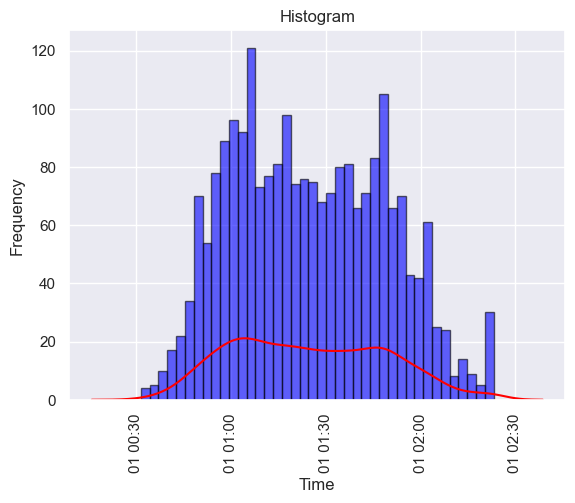

In [116]:
# visualize the distribution race finishes in every 3 minutes

df_race_results = df_race_results.sort_values(by='Time')

# the first person finished in 31 minute.The last person finished in 2:23 minutes. so this meas the number of bins is 40

# create a histogram based on each class
# Plot the histogram for a specific column
plt.hist(df_race_results['Time'], bins=40, alpha=0.6, edgecolor='black', color='blue', label='Histogram')

# Add a density line (kernel density estimate)
sns.kdeplot(df_race_results['Time'], color='red', label='Density Line')

plt.title('Histogram')
plt.xlabel('Time')
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.show()


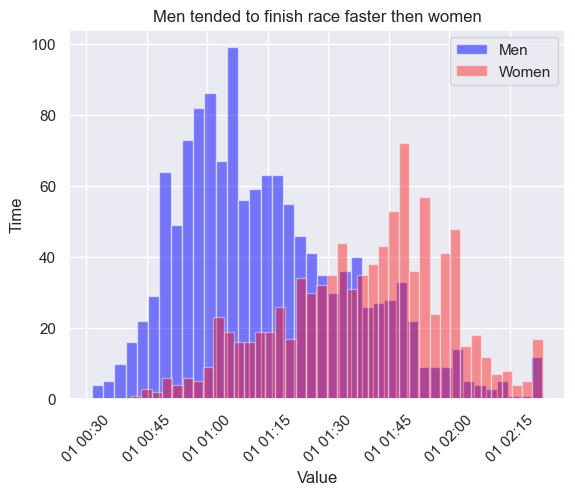

In [117]:
# Plot overlapping histograms
plt.hist(df_race_results[df_race_results['Gender'] == 'M']['Time'], bins=40, alpha=0.5, label='Men', color='blue')
plt.hist(df_race_results[df_race_results['Gender'] == 'W']['Time'], bins=40, alpha=0.4, label='Women', color='red')

# Set labels and title
plt.title('Men tended to finish race faster then women')
plt.xlabel('Value')
plt.xticks(rotation=45)
plt.ylabel('Time')

# Add a legend
plt.legend()

# Show the plot
plt.show()

### 2. which Class had the fastest finish time?

In [118]:
df_race_results['Time'].groupby(df_race_results['Class']).describe(datetime_is_numeric=True)

,count,mean,min,25%,50%,75%,max
Class,,,,,,,
FEDERADOS,295,1900-01-01 01:23:21.145762560,1900-01-01 00:31:21,1900-01-01 01:02:42.500000,1900-01-01 01:21:59,1900-01-01 01:44:15,1900-01-01 02:22:18
POPULARES,1393,1900-01-01 01:24:15.645369600,1900-01-01 00:35:11,1900-01-01 01:03:57,1900-01-01 01:22:48,1900-01-01 01:44:11,1900-01-01 02:23:08
VETERANOS,580,1900-01-01 01:26:36.689655552,1900-01-01 00:34:23,1900-01-01 01:06:12,1900-01-01 01:23:58,1900-01-01 01:45:29.249999872,1900-01-01 02:22:54


In [119]:
df_race_results['Time'].groupby(df_race_results['Gender']).describe(datetime_is_numeric=True)

,count,mean,min,25%,50%,75%,max
Gender,,,,,,,
M,1338,1900-01-01 01:14:48.232436224,1900-01-01 00:31:21,1900-01-01 00:58:47,1900-01-01 01:10:46.500000,1900-01-01 01:28:08.750000128,1900-01-01 02:22:58
W,930,1900-01-01 01:39:02.663441152,1900-01-01 00:41:06,1900-01-01 01:25:04.249999872,1900-01-01 01:42:00.500000,1900-01-01 01:53:36.500000,1900-01-01 02:23:08


In [120]:
df_race_results['Time'].groupby(df_race_results['Age_group']).describe(datetime_is_numeric=True)

,count,mean,min,25%,50%,75%,max
Age_group,,,,,,,
15-19,128,1900-01-01 01:20:39.914062592,1900-01-01 00:44:13,1900-01-01 01:03:27.249999872,1900-01-01 01:20:03,1900-01-01 01:38:05,1900-01-01 02:15:41
20-39,1373,1900-01-01 01:23:17.872542208,1900-01-01 00:31:21,1900-01-01 01:02:37,1900-01-01 01:21:32,1900-01-01 01:44:11,1900-01-01 02:23:08
40-49,553,1900-01-01 01:26:43.312838912,1900-01-01 00:34:23,1900-01-01 01:07:20,1900-01-01 01:24:47,1900-01-01 01:44:28,1900-01-01 02:22:50
50-59,169,1900-01-01 01:29:24.207100416,1900-01-01 00:42:44,1900-01-01 01:05:58,1900-01-01 01:29:53,1900-01-01 01:48:51,1900-01-01 02:22:54
60-69,40,1900-01-01 01:38:26.499999744,1900-01-01 00:41:57,1900-01-01 01:15:18.500000,1900-01-01 01:44:21.500000,1900-01-01 01:54:10.750000128,1900-01-01 02:22:58
70,5,1900-01-01 01:40:20.200000,1900-01-01 01:13:46,1900-01-01 01:37:20,1900-01-01 01:42:54,1900-01-01 01:48:49,1900-01-01 01:58:52


In [121]:
# # Set up subplots for each category
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

# # Plot histograms for each category
# for ax, (Class, subset) in zip(axes, df_race_results.groupby('Class')):
#     sns.histplot(subset['Time'], bins=30, kde=True, ax=ax, label=f'Class {Class}')
#     ax.set_title(f'Histogram for Category {Class}')
#     ax.set_xlabel('Value')
#     ax.set_ylabel('Density/Frequency')
#     ax.legend()

# # Adjust layout
# plt.tight_layout()


# # Show the plot
# plt.show()

### 3. How many countries participated? Show the top 3 finishes per country

In [122]:
# distinct count of nations
df_race_results['Nation'].nunique()

24

In [123]:
# Visualize a bar chart of count of rows by Nation sorted top down excluding Mozambique
df_race_results['Nation'].value_counts().sort_values(ascending=False)

 MOZ    2170
 SWZ      20
 POR      12
 RSA      10
 USA       9
 ZIM       7
 VIE       6
 JPN       6
 GBR       5
 FRA       4
 BRA       3
 ESP       3
 RWA       2
 POL       1
 GER       1
 COD       1
 BEL       1
 ECU       1
 KEN       1
 DEN       1
 NED       1
 NZL       1
 NAM       1
 MON       1
Name: Nation, dtype: int64

In [124]:
sqldf(""" WITH Rank_by_nation as (
                SELECT 
                    Name, Nation, Class, TIME(Time) as Time, DENSE_RANK() OVER (PARTITION BY Nation ORDER BY Time) as Rank_by_nation
                from 
                    df_race_results 
                ),
                participing_nations as (
                    SELECT Nation, count(*) as N_participants
                    from df_race_results
                    group by Nation
                )

                SELECT 
                    Rank_by_nation.* 
                from 
                    Rank_by_nation 
                join 
                    participing_nations on Rank_by_nation.Nation = participing_nations.Nation
                where 
                    Rank_by_nation <=3 and N_participants > 2
                order by 
                    Nation

            """)

,Name,Nation,Class,Time,Rank_by_nation
0,Antonio Carlos Bordim Cervi,BRA,VETERANOS,00:52:04,1
1,Pedro Timoteo,BRA,VETERANOS,01:02:03,2
2,Victor Holanda Araujo,BRA,POPULARES,01:10:30,3
3,Clara Molera,ESP,VETERANOS,00:58:48,2
4,Daniel Gonzalez Levassor,ESP,VETERANOS,00:57:11,1
5,Maria Salazar Gonzalez,ESP,VETERANOS,01:52:27,3
6,Clemence Guitard,FRA,POPULARES,00:56:52,3
7,Heloise Lemaire,FRA,POPULARES,00:52:07,1
8,Valentin Mifsud,FRA,POPULARES,00:56:10,2
9,David Reid,GBR,VETERANOS,01:09:44,2


### 4. What are the top 3 finishes per Class and per gender?

In [125]:
sqldf(""" WITH Rank_by_class as (
                SELECT 
                    Name, 
                    Class, 
                    Gender,Nation, 
                    TIME(Time) as Time, 
                    DENSE_RANK() OVER (PARTITION BY Class, Gender ORDER BY Time) as class_rank
                from 
                    df_race_results 
                )

                SELECT 
                    * 
                from 
                    Rank_by_class
            
                where 
                    class_rank <=3 
                order by 
                    Class, 
                    Gender

            """)

,Name,Class,Gender,Nation,Time,class_rank
0,Abednico Mashaba,FEDERADOS,M,RSA,00:31:21,1
1,Princip Dlhovo,FEDERADOS,M,MOZ,00:31:29,2
2,Titosse Taimo,FEDERADOS,M,MOZ,00:32:56,3
3,Neviah Maganzo,FEDERADOS,W,MOZ,00:41:06,1
4,Rosa Taimo,FEDERADOS,W,MOZ,00:46:00,2
5,Sabina Arlindo Tembe Tembe,FEDERADOS,W,NAM,00:46:36,3
6,Samuel Julio Savanguane,POPULARES,M,MOZ,00:35:11,1
7,Nelito Gogo,POPULARES,M,MOZ,00:35:28,2
8,Lucian Quissico,POPULARES,M,MOZ,00:36:40,3
9,Sandra Francisco,POPULARES,W,MOZ,00:45:26,1


### 5. In what percentile am I? Overall and per category?

if we follow the formula P = (n/N) × 100 we can calculate how close I was to top performs. Since we have Rank by default, overall percentile will be quick. But to calculate based on class and category, need to find my ranking within those

#### Overall percentile

Let's quickly look at my overall rank

In [126]:
tassio_result = sqldf("""SELECT * from df_race_results where name like 'Tássio%' """)
tassio_result

,Rank,Name,Nation,Class,Category,Time,Gender,Age_group,Rank_by_class,Rank_by_Category
0,383,Tássio Rosário,MOZ,POPULARES,M20-39,1900-01-01 00:59:15.000000,M,20-39,219,225


In [127]:
count_all = df_race_results['Rank'].count()
rank_overall = int(tassio_result['Rank'])
percentile_overall = (rank_overall/count_all) * 100
print(f'From a total of {count_all} participants, I ranked {rank_overall}th, putting me in the top {round(percentile_overall, 0)}% of the class')

From a total of 2268 participants, I ranked 383th, putting me in the top 17.0% of the class


In [128]:
count_class = df_race_results[df_race_results['Class'] == tassio_result['Class'][0]]['Rank'].count()
rank_class = int(tassio_result['Rank_by_class'])
percentile_class = (rank_class/count_class) * 100
print(f'From a total of {count_class} participants in class, I ranked {rank_class}th, putting me in the top {round(percentile_class, 0)}% of the class')

From a total of 1393 participants in class, I ranked 219th, putting me in the top 16.0% of the class


In [129]:
count_category = df_race_results[df_race_results['Category'] == tassio_result['Category'][0]]['Rank'].count()
rank_category = int(tassio_result['Rank_by_Category'])
percentile_category = (rank_category/count_category) * 100
print(f'From a total of {count_category} participants in category, I ranked {rank_category}th, putting me in the top {round(percentile_category, 0)}% of the category')

From a total of 835 participants in category, I ranked 225th, putting me in the top 27.0% of the category


Now that I know my placement, it is time to look for insights that can help me improve my time.

### 6. What would be the Average pace for me to be Top 10 in my class?

To Answer this question we need to calculate the average pace for every racer in the dataframe. The formula is to divide the total time by 10 KM, which is the total distance ran in the event

In [130]:
# create a Pace column that divides Time by 10
km_ran = 10
# Step 1: Calculate Pace for Each Runner

df_race_results['total_race_seconds'] = (df_race_results['Time'] - pd.to_datetime('1900-01-01')).dt.total_seconds()
df_race_results['Avg_pace_seconds'] = df_race_results['total_race_seconds'] / km_ran

# Convert pace to a more readable format (e.g., minutes per mile)
# If your distance is in kilometers, you might want to adjust this conversion accordingly
df_race_results['Avg_pace'] = pd.to_datetime(df_race_results['Avg_pace_seconds'], unit='s').dt.strftime('%H:%M:%S')


In [131]:
df_race_results

,Rank,Name,Nation,Class,Category,Time,Gender,Age_group,Rank_by_class,Rank_by_Category,total_race_seconds,Avg_pace_seconds,Avg_pace
0,1,Abednico Mashaba,RSA,FEDERADOS,M20-39,1900-01-01 00:31:21,M,20-39,1,1,1881.0,188.1,00:03:08
1,2,Princip Dlhovo,MOZ,FEDERADOS,M20-39,1900-01-01 00:31:29,M,20-39,2,2,1889.0,188.9,00:03:08
2,3,Titosse Taimo,MOZ,FEDERADOS,M20-39,1900-01-01 00:32:56,M,20-39,3,3,1976.0,197.6,00:03:17
3,4,Nazareno Domingos,MOZ,FEDERADOS,M20-39,1900-01-01 00:33:18,M,20-39,4,4,1998.0,199.8,00:03:19
4,5,Bento Gervásio Ianquine Itato,MOZ,VETERANOS,M40-49,1900-01-01 00:34:23,M,40-49,1,1,2063.0,206.3,00:03:26
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2263,2264,Júlio Monteiro,MOZ,VETERANOS,M40-49,1900-01-01 02:22:50,M,40-49,537,274,8570.0,857.0,00:14:17
2264,2265,Daniele Pepe,MOZ,VETERANOS,M50-59,1900-01-01 02:22:51,M,50-59,538,97,8571.0,857.1,00:14:17
2265,2266,Amad Mahomed,MOZ,VETERANOS,M50-59,1900-01-01 02:22:54,M,50-59,539,98,8574.0,857.4,00:14:17
2266,2267,Daniel Filepe Massango,MOZ,POPULARES,M60-69,1900-01-01 02:22:58,M,60-69,1196,23,8578.0,857.8,00:14:17


Now that we have the Average pace calculated for each runner, I can now compare my pace to the 10th place in my category. Let's first see my Average Pace

In [132]:
tassio_result = sqldf("""SELECT * from df_race_results where name like 'Tássio%' """)
tassio_result

,Rank,Name,Nation,Class,Category,Time,Gender,Age_group,Rank_by_class,Rank_by_Category,total_race_seconds,Avg_pace_seconds,Avg_pace
0,383,Tássio Rosário,MOZ,POPULARES,M20-39,1900-01-01 00:59:15.000000,M,20-39,219,225,3555.0,355.5,00:05:55


My average pace was 5:55 min per KM. Now let's extract every racer result that ranked 10th in each Class

In [133]:
sqldf("""SELECT * from df_race_results where Rank_by_Class =  10 """)

,Rank,Name,Nation,Class,Category,Time,Gender,Age_group,Rank_by_class,Rank_by_Category,total_race_seconds,Avg_pace_seconds,Avg_pace
0,18,Camilo Joao,MOZ,POPULARES,M20-39,1900-01-01 00:39:13.000000,M,20-39,10,16,2353.0,235.3,00:03:55
1,66,Rosa Taimo,MOZ,FEDERADOS,W15-19,1900-01-01 00:46:00.000000,W,15-19,10,1,2760.0,276.0,00:04:36
2,95,Paulo Barca Alves,MOZ,VETERANOS,M40-49,1900-01-01 00:48:15.000000,M,40-49,10,7,2895.0,289.5,00:04:49


Wow! In order to be in the top 10 in my class I would need to shave 2 min of my average pace! There's a lot of work to do there an, by doing that, I would be in the top 20 overall. Now, let's do same extraction but looking into the Category

In [134]:
sqldf("""SELECT * from df_race_results where Rank_by_Category =  10 """)

,Rank,Name,Nation,Class,Category,Time,Gender,Age_group,Rank_by_class,Rank_by_Category,total_race_seconds,Avg_pace_seconds,Avg_pace
0,11,Valdo Lourenço,MOZ,POPULARES,M20-39,1900-01-01 00:37:32.000000,M,20-39,5,10,2252.0,225.2,00:03:45
1,109,Inácio Inácio,MOZ,FEDERADOS,M40-49,1900-01-01 00:48:53.000000,M,40-49,19,10,2933.0,293.3,00:04:53
2,214,Pedro Paulino,MOZ,VETERANOS,M50-59,1900-01-01 00:53:31.000000,M,50-59,33,10,3211.0,321.1,00:05:21
3,219,Essien Mondlane,MOZ,POPULARES,M15-19,1900-01-01 00:53:47.000000,M,15-19,138,10,3227.0,322.7,00:05:22
4,226,Arlindo Tomás Mambo Mambo,MOZ,POPULARES,W20-39,1900-01-01 00:54:12.000000,W,20-39,142,10,3252.0,325.2,00:05:25
5,499,Assia Zena Jamal,MOZ,VETERANOS,W40-49,1900-01-01 01:02:38.000000,W,40-49,100,10,3758.0,375.8,00:06:15
6,879,Wane Duduzane Kaonga,MOZ,POPULARES,W15-19,1900-01-01 01:14:32.000000,W,15-19,469,10,4472.0,447.2,00:07:27
7,986,Maria Dava,MOZ,VETERANOS,W50-59,1900-01-01 01:17:46.000000,W,50-59,232,10,4666.0,466.6,00:07:46
8,1134,Armando Mussuei,MOZ,VETERANOS,M60-69,1900-01-01 01:23:11.000000,M,60-69,262,10,4991.0,499.1,00:08:19
9,1960,Marcelina Francisco Machava,MOZ,VETERANOS,W60-69,1900-01-01 01:53:24.000000,W,60-69,462,10,6804.0,680.4,00:11:20


By looking at my category (M20-39), I'll need to shave some extra 10 seconds! Don't know what proper training I'll have to do, but now I definitely have a target to beat!